In [153]:
import pandas as pd
from konlpy.tag import Okt
from konlpy.tag import Mecab
import re

import matplotlib
import matplotlib.font_manager as fm
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # matplotlib 한글 맑은 고딕 폰트 설정
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import requests
from bs4 import BeautifulSoup
import json
import time

okt = Okt()
mecab = Mecab()

In [253]:
#키워드 리뷰 불러오기
def topic_review(topic):
    
    reviews = []
    for review in review_list:
        if topic in review:
            reviews.append(review)
            
    return reviews

def view_wordrank(document, max_words, ngram_min=1,ngram_max=3, min_df=2, max_df=0.8):
    
    tf_vect = CountVectorizer(ngram_range=(ngram_min,ngram_max), min_df = min_df, max_df = max_df)
    dtm = tf_vect.fit_transform(document)

    vocab = dict()
    for idx, word in enumerate(tf_vect.get_feature_names()):
        vocab[word] = dtm.getcol(idx).sum()
    words = sorted(vocab.items(), key = lambda x: x[1], reverse = True)

    max = max_words
    plt.figure(figsize=(30,20))
    plt.bar(range(max), [i[1] for i in words[:max]])
    plt.title('Frequency Top {}'.format(max_words))
    plt.xlabel('단어')
    ax = plt.subplot()
    ax.set_xticks(range(max))
    ax.set_xticklabels([i[0] for i in words[:max]], rotation=30, size=20)
    plt.show()
    
    return vocab

#LDA & DTM
def get_dtm(document, ngram_min=1, ngram_max=3, n_topics=10, n_words=20):
    
    tf_vect = CountVectorizer(ngram_range = (ngram_min,ngram_max), max_df = 0.8, min_df = 2)
    dtm = tf_vect.fit_transform(document)

    n_topics= n_topics
    lda = LatentDirichletAllocation(n_components = n_topics, topic_word_prior=0.01, doc_topic_prior=0.01)
    lda.fit(dtm)

    names = tf_vect.get_feature_names()
    topics = dict()
    n_words = n_words

    for idx, topic in enumerate(lda.components_):
        vocab = []
        for i in  topic.argsort()[:-(n_words-1):-1]:
            vocab.append((names[i], topic[i].round(2)))
        topics[idx+1] = [(names[i], topic[i].round(2)) for i in  topic.argsort()[:-(n_words-1):-1]]

    dtm_matrix = lda.transform(dtm)    
    
    return tf_vect, lda, dtm, topics, dtm_matrix

#주제에 해당하는 리뷰 10개씩 출력
def get_RepReview(dtm_matrix):
    
    review_dict = dict()
    for idx, vec in enumerate(dtm_matrix):
        #idx는 리뷰의 index
        t = vec.argmax() # 해당 리뷰가 속한 topic num
        
        if (t not in review_dict): # 맨 처음
            review_dict[t] = []
            review_dict[t].append((vec[t], idx))
        elif len(review_dict[t]) < 10: #10개까지 채우기
            review_dict[t].append((vec[t], idx))
        else: #10개가 꽉 찬 상황이야.
            review_dict[t].sort()
            if vec[t] > review_dict[t][0][0]:#가장 연관성이 떨어지는 리뷰의 점수
                review_dict[t][0] = (vec[t], idx)
            else:
                pass
            #너무 쓸데없이 연산이 많이 돌아가겠지만 일단 해보자

    sorted_review = sorted(review_dict.items(), key = lambda x: x[0], reverse=False)

    for key, value in sorted_review:
        print('<주제 {}>'.format(key + 1))
        for score, idx in value:
            print(review_list[idx])
        print('\n')

In [170]:
review_list = []
pages = 100
for page in range(pages):
    try:
        url = 'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?ticket=auto1&templateId=&pool=cbox&_callback=jQuery1707609017391243922_1608381365685&lang=ko&country=&objectId=137863&categoryId=&pageSize=10&indexSize=10&groupId=&listType=OBJECT&pageType=default&page={}&refresh=false&sort=NEW&_=1608382297292'.format(page)
        params = {'ticket': 'auto1',
        # templateId: 
        'pool': 'cbox',
        '_callback': 'jQuery1707609017391243922_1608381365682',
        'lang': 'ko',
        # country: 
        'objectId': '137863',
        # 'categoryId': 
        'pageSize': 10,
        'indexSize': 10,
        # 'groupId': 
        'listType': 'OBJECT',
        'pageType': 'default',
        'page': page,
        'refresh': 'false',
        'sort': 'NEW',
        '_': 1608381559312}
        headers = {'referer': 'https://auto.naver.com/car/talk.nhn?yearsId=137863',
                  'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'}
        time.sleep(5)
        resp = requests.get(url, data= params, headers = headers)
        soup = BeautifulSoup(resp.content, 'lxml')

        data = resp.text[resp.text.index('(') + 1 : resp.text.rindex(')')]
        temp_parser = json.loads(data)

        review_per_page = 10
        for i in range(review_per_page):
            contents = temp_parser['result']['commentList'][i]['contents']
            review_list.append(contents)
    except:
        print(page)
        
review_list = set(review_list)
len(review_list)

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [246]:
review_list = list(set(review_list))

# 명사 + @

In [255]:
review_token = []
for review in review_list:
    review = re.sub('([a-zA-Z])','',review)
    review = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',review)
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',review)
    temp_token = []
    for word, pos in mecab.pos(review):
        if pos in ['NNG', 'NNP', 'VV', 'VA', 'VX', 'VCP', 'VCN', 'MAG']:
            temp_token.append(word)
    review_token.append((' ').join(temp_token))
    
review_token[:10]

<>:5: DeprecationWarning: invalid escape sequence \?
<>:5: DeprecationWarning: invalid escape sequence \?
<>:5: DeprecationWarning: invalid escape sequence \?
<ipython-input-255-e7ac38b457a2>:5: DeprecationWarning: invalid escape sequence \?
  review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',review)


['',
 '다 디자인 나오 큰일나 나오 소비자 엠블럼 사 후반 스타트 중반 부탁 사장 반드시 계약',
 '확실히 전 고급 그릴 좀 어떻 못하',
 '진짜 지 옆모습 쩔 버리',
 '기통 디젤 없 너무 아쉽 과연 기통 디젤 소음',
 '존재감 지 릴',
 '옆모습 보',
 '디자인 세계 세단 최고 깡통 상당히 좋',
 '가까이 보 대박 차',
 '선루프 포함 풀 견적 메일 부탁']

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


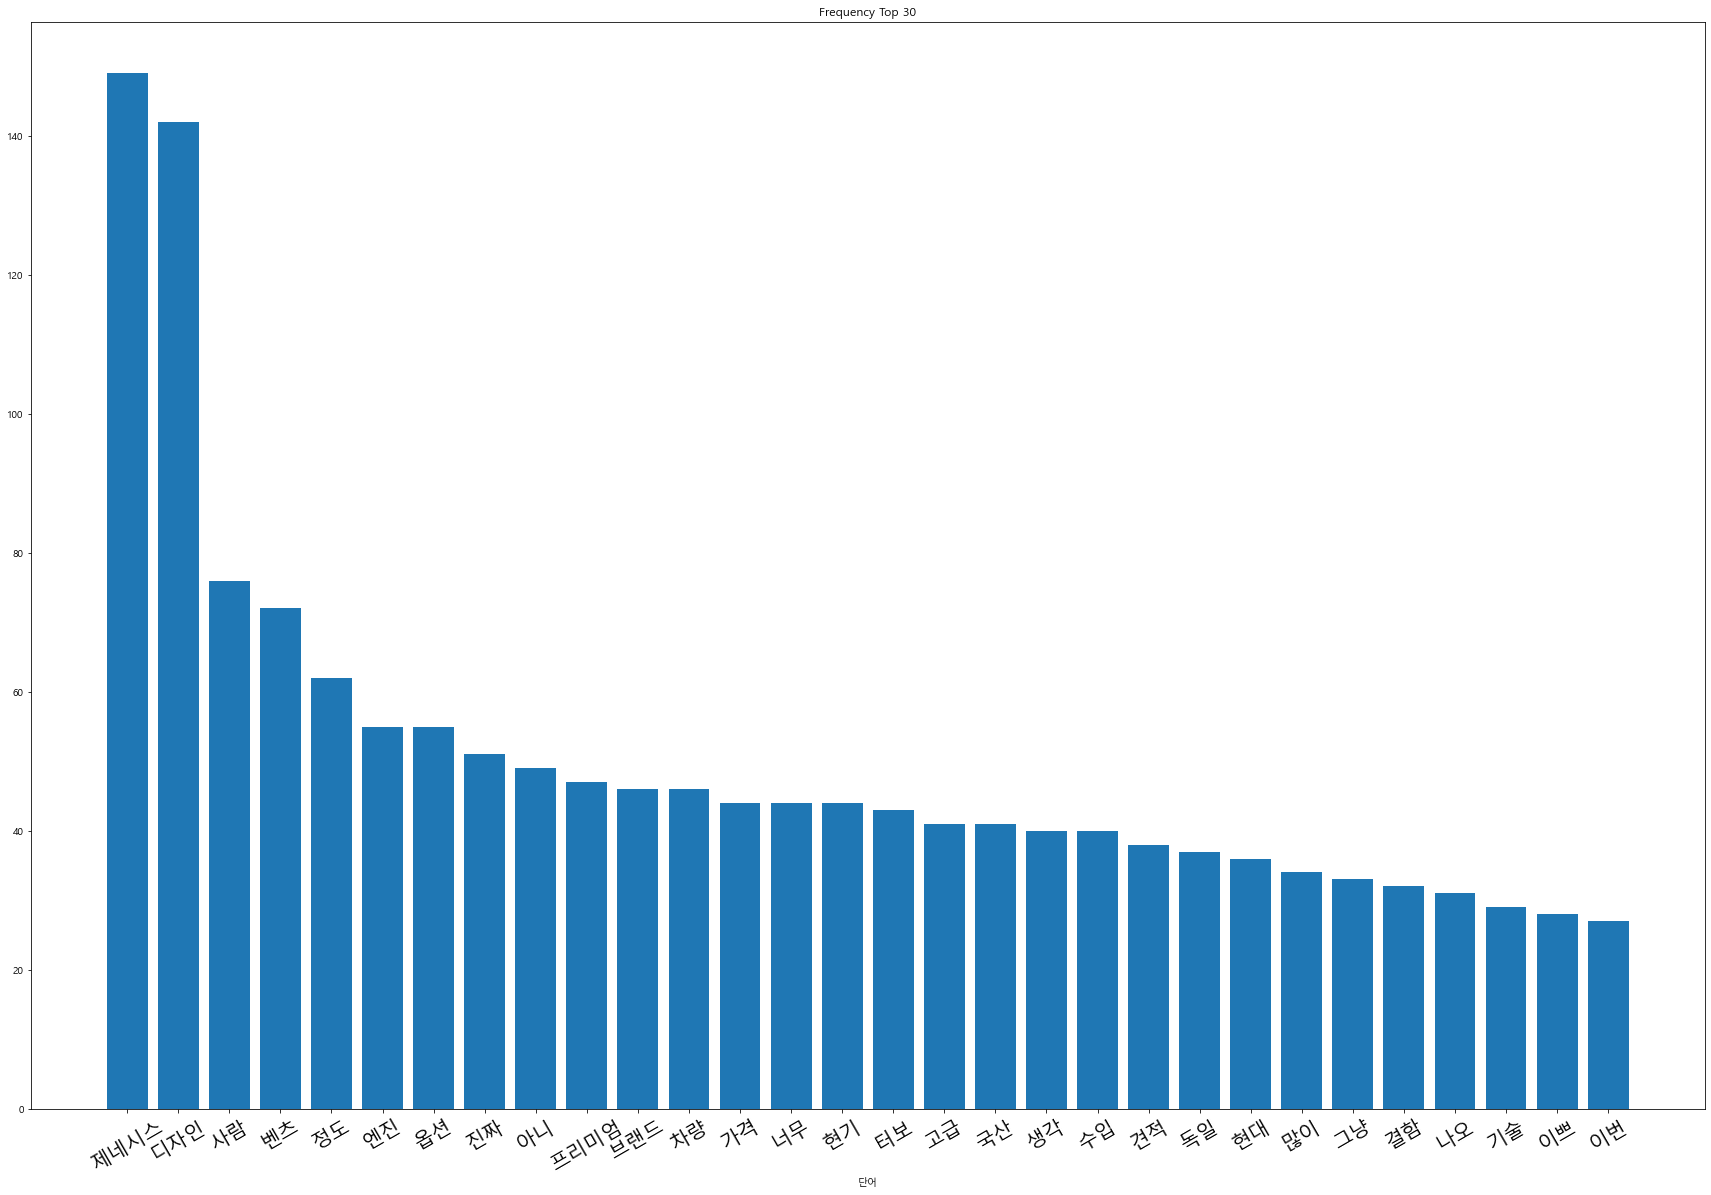

In [256]:
token_vocab = view_wordrank(review_token, max_words=30)

# 명사토큰

In [ ]:
review_nouns = []
for review in review_list:
    review = re.sub('([a-zA-Z])','',review)
    review = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',review)
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',review)
    temp_token = []
    for word in mecab.nouns(review):
        temp_token.append(word)
    review_nouns.append((' ').join(temp_token))

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


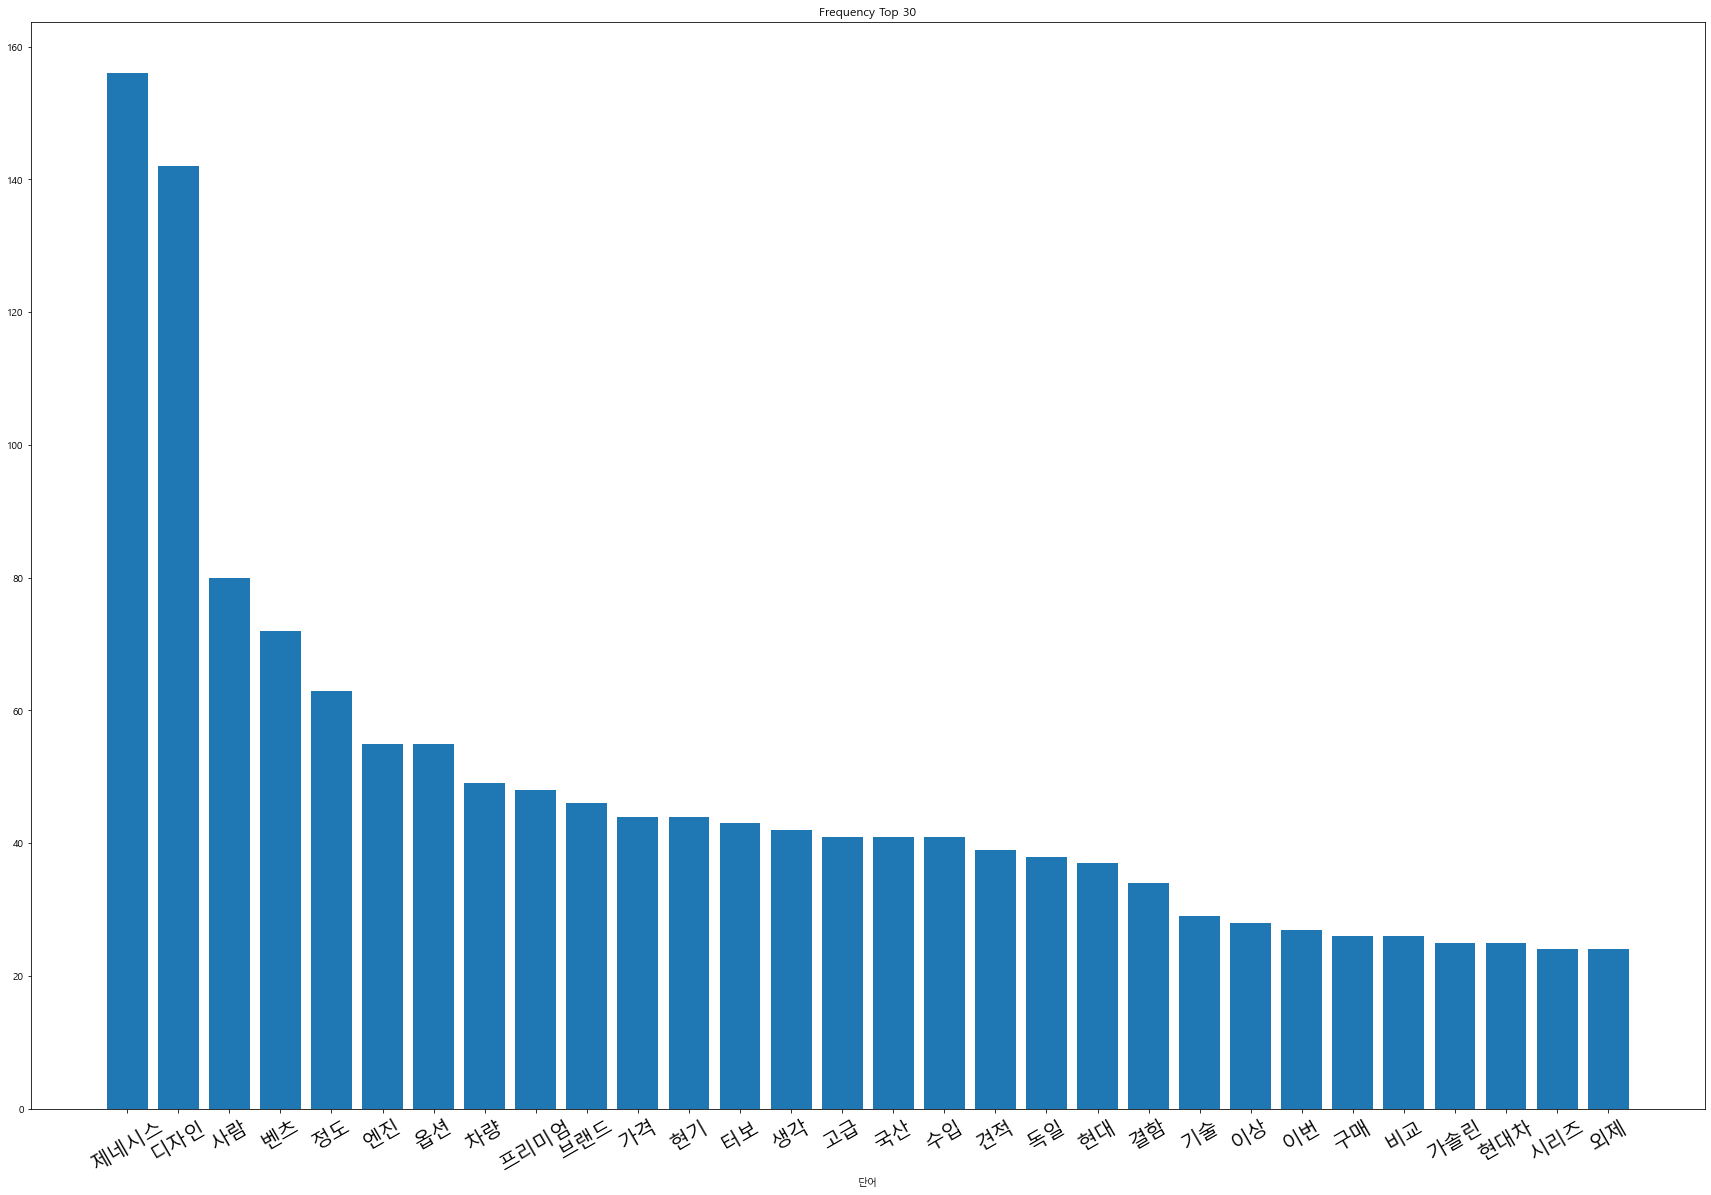

In [257]:
token_vocab = view_wordrank(review_nouns, max_words=30)

In [191]:
topic_review('벤츠')

['차가 고장도 안나고 18년이 지났는데 벤츠S도 타봤는데 특별히 내차를 욕할 이유가 없다라고 느낌 18년전에 2,300만원 주고 산 차를 아직도 탄다는 거에 감사하고 있습니다. 그당시는 제네시스 부럽지 않았던 차',
 '벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ\n벤츠보다 30년 뒤떨어진 엔진 기술',
 '12f2sd님\nBEST풀옵으로 이정도 차살정도 능력되는사람은 bmw를타든 벤츠를 타든 다탄다 비엠보다뭐가 어쩌고 벤츠보다 뭐 어쩌고 할사람들은 애초에 이차를 구매할 능력이 안된다는것이 팩트\n\nWilliam Kim님\n독일차 매니아들이 우르르 몰려와 악평을 남기는데 혈안이 되어있네요. 신형 G80이 그저 무시할 만한 모델이 아니라는 것에 대한 반증으로 보입니다.',
 '벤츠보다 30년 뒤떨어진 엔진 기술 ㅋㅋㅋ',
 '결국은 현기일뿐..제네시스 풀옵이 얼마정도하지? 1억은 되려나?\n뭐 1억 좀 넘는다 가정해도..그 돈으로 벤츠나 비엠 깡통 사겠네..벤츠나 비엠도 등급이 나뉘는데 낮은 등급 차량들하고 현기 최고등급이랑 

# 토픽 수 별 비교

In [250]:
tf_vect, lda, dtm, topics, dtm_matrix = get_dtm(review_token, n_topics=5)
get_RepReview(dtm_matrix)

<주제 1>
2.5 터보 / 하바나 브라운 모노톤 / 드라이빙 어시스턴스 패키지I / 차량보호필름 / 현금일시불 / cdam3003@naver.com
풀옵으로 이정도 차살정도 능력되는사람은 bmw를타든 벤츠를 타든 다탄다 비엠보다뭐가 어쩌고 벤츠보다 뭐 어쩌고 할사람들은 애초에 이차를 구매할 능력이 안된다는것이 팩트
구매희망 : 2.5 터보 /로얄블루 또는 테즈먼블루/ 하바나 브라운 모노톤 / 드라이빙 어시스턴스 패키지I / 차량보호필름 / 현금일시불 / tongil@naver.com
궁금한게 있는데 완전 구형 아니고 약간 된 차량들.. c클 e클 3시리즈 5시리즈 왜 악셀 밟다가 떼면 뒤에서 누가 당기듯이 차량이 제동이 걸리는 듯한 현상이 나타나는거죠? 이거 진짜임 . 내장도 플라덩어리에 옵션도 못넣은건지 그저그렇고 그럴꺼면 차라리 제네시스를 사든지.. 제네는 진짜 오히려 괜찮은데 왜까나요? 외제차는 그냥 마크 빨 인거 같아요. 7시리즈나 s 클은 정말 괜찮긴 하더라구요. 독일차 별거 없어요.  여러분 운동 성능? 외제차 suv 타보세요 휘청휘청 거려요. 이것도 진짜임. 서스가 기술이다? 우리나라차 휘청거리면 기술로 까고 외제차는 그것도 기술인가요 진짜 비싼 독일차 좋아요 하지만 제네시스가 까일만한 똥차도 아님
부모를 잘만나지 않은 이상 이차도 타기는 쉽지 않다.. 누가 그러던데..300~500버는 사람들이 타는 차라고... 혼자사나?? 700이 넘어도... 고민하다 결정했는데....주변에서 이정도 타도 성공한거 아닌가? 라더라. 외제차? 독삼사 좋은줄 누가 모르나... p사 차 타는 여직원 1만원정도의 브라켓 하나 바꾸는데 40만원 넘게 들더라..국산차였으면 5만원이면 된다던데..b사타는 남직원 조향쪽 문제있다고 수리들어가더니 (큰문제도 아니었음) 212만원... 그들의 선택이니 뭐라 할 건 없다..다만 나같이 50만원으로 해결될거 몇백만원 들이는게 아까운 사람들은 외산차 안타거나 못타는 것일 뿐....20살부터 차7대째 타고 있지만..중간에 외제차 한번 

In [251]:
tf_vect, lda, dtm, topics, dtm_matrix = get_dtm(review_token, n_topics=10)
get_RepReview(dtm_matrix)

<주제 1>
저 덩치와 크기로 볼때 2.5보단 3.5가 어울릴 듯! 세금이나 연비를 생각하면 2.5를 선택하는 게 나을 듯! 다만 디젤은 저런 대형세단에 육박하는 크기에 어울리지 않는!
국내에 너무 비싸게 팔아. 국내 소비자가 무슨봉도 아니고, 그런다고 수출차량보다 더 좋지도 않고, 벤츠도 할인받으면 살수 있는 금액인데, 현대차 정신차려야 합니다
짱깨국한테도 개무시당하는 제네시스 브랜드가지고 급타령 하면 안민망하나? 어서 렉서스한테도 안되는 듣보  잡브랜드가지고 독일 프리미엄을 갖다 붙이냐 ~ 가격때문이냐? ㅋㅋㅋㅋㅋㅋㅋㅋㅋ
두 선과의 조화, 옆 모습은 독일 모사 A7 닮은 꼴이지만  그래도 디자인 멋있다. 대형 LCD 모니터 보긴 좋은 데 작동 관련 팔길이 고려한 조작 거리일까 궁금?  직사광선 비칠 때 가독성 좋은 지도 궁금?  기어노브가 타차종의 push button 보다는 Rotary type이 휴먼에러 유발가능성은 낮아 보일 듯?  모든 기능 조작이 모니터로 집결되면 운전자의 운전 집중도는 저해할 수도?
장기렌트 문의 카톡ID : seung3949     
(보험료+자동차세= 월렌트료)
초기비용 X
재고차량 보유
신차 장기렌트 문의 카톡ID : seung3949     (보험료 자동차세 렌트료포함)

초기비용x
느낌이... 헤드램프는 CLS 2011년식, 전체 라인과 리어램프는 구형A7. 디자인 업계에 있는 나에게도 가장 기억에 남는 멋진 부분들 이었는데 자동차 디자이너들은 당연히 눈여겨 봤겠지. 두줄을 넣고 더 멋져졌지만 그런 부분들의 느낌은 지울수 없음. 그릴 크기와 모양의 독창성과 완성도는 인정
중국 대형 프리미엄세단 홍치 H9스펙 : V6 싱글터보/8단DCT변속기/후륜 에어서스/ 2.5L 레벨 반자율/통풍+무중력시트/ 메트릭스 LED / 롤스로이스디자이너영입 훌륭한 내외 디자인 / 원목트림 + 고급가죽도배 / S클래스 기함체급 이게 4천대이고 이게 가성비지~ 그나마 가성비밖에 없었는데 제네시스 미래가 어둡네 ㅋㅋㅋ G80 G90 원가 공개해봐라

In [ ]:
import pyLDAvis.sklearn

visual = pyLDAvis.sklearn.prepare(lda_model=lda, dtm=dtm, vectorizer=tf_vect)
pyLDAvis.display(visual)